# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions

from pymc_marketing.clv.models import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

In [2]:
url_cdnow_rfm = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/clv_quickstart.csv"
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"

df = pd.read_csv(url_cdnow_rfm)
df['customer_id'] = df.index

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
 4   customer_id     2357 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 92.2 KB


In [3]:
df.head(5)

,frequency,recency,T,monetary_value,customer_id
0,2,30.43,38.86,22.35,0
1,1,1.71,38.86,11.77,1
2,0,0.00,38.86,0.00,2
3,0,0.00,38.86,0.00,3
4,0,0.00,38.86,0.00,4


In [4]:
df.describe()

,frequency,recency,T,monetary_value,customer_id
count,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000
mean,1.042427,6.845787,32.715829,14.079045,1178.000000
std,2.190014,10.731400,3.326906,25.760960,680.551615
min,0.000000,0.000000,27.000000,0.000000,0.000000
25%,0.000000,0.000000,29.860000,0.000000,589.000000
50%,0.000000,0.000000,32.710000,0.000000,1178.000000
75%,1.000000,12.000000,35.430000,21.360000,1767.000000
max,29.000000,38.430000,38.860000,299.630000,2356.000000


## Lifetimes Comparison

{'r': 0.5532631052128189,
 'alpha': 10.577412770186461,
 's': 0.6062085898176242,
 'beta': 11.668105047300301}

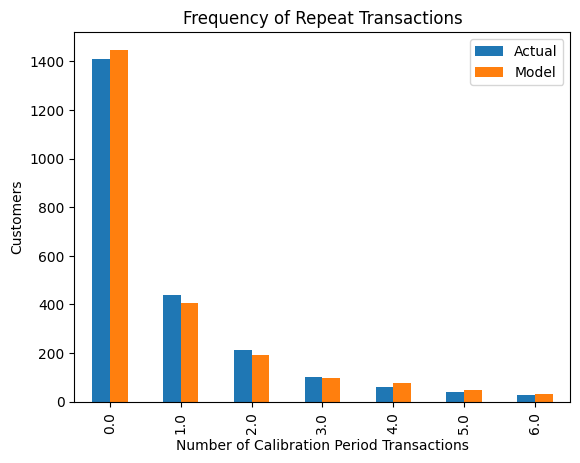

In [21]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

lft = ParetoNBDFitter()
lft.fit(x, t_x, T)
lt_fit = dict(lft.params_)

plot_period_transactions(lft)

lt_fit

Use the `ParetoNBD` distribution from `pymc-marketing` to simulate frequency and recency from fitted Lifetimes model parameters. This is useful for generating synthetic data as well as checking how well the parameters fit the original data.

This forms the basis of the `plot_period_transactions` plot from `lifetimes`.

In [6]:
rec_freq = pm.draw(ParetoNBD.dist(r=0.55,
                alpha=10.58,
                s=0.61,
                beta=11.67,
                T=T,
                size=len(T)))

pd.DataFrame({'frequency': rec_freq[...,1], 'recency': rec_freq[...,0], "T": T}).describe()

,frequency,recency,T
count,2357.000000,2357.000000,2357.000000
mean,1.060670,6.861310,32.715829
std,2.069703,10.732657,3.326906
min,0.000000,0.000000,27.000000
25%,0.000000,0.000000,29.860000
50%,0.000000,0.000000,32.710000
75%,1.000000,12.633192,35.430000
max,21.000000,38.264921,38.860000


<Axes: >

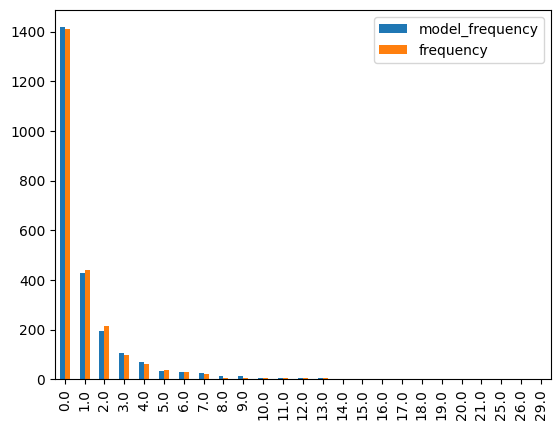

In [7]:
model_freq = rec_freq[...,1]

actual_counts = pd.Series(x).value_counts().sort_index()
simulated_counts = pd.Series(model_freq).value_counts().sort_index()
combined_counts = pd.DataFrame({"model_frequency": simulated_counts, "frequency": actual_counts}).fillna(0)
combined_counts.plot(kind="bar")

## PyMC Comparison

Construct an equivalent model with PyMC to illustrate the inner workings of the pymc-marketing model for comparison. 

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

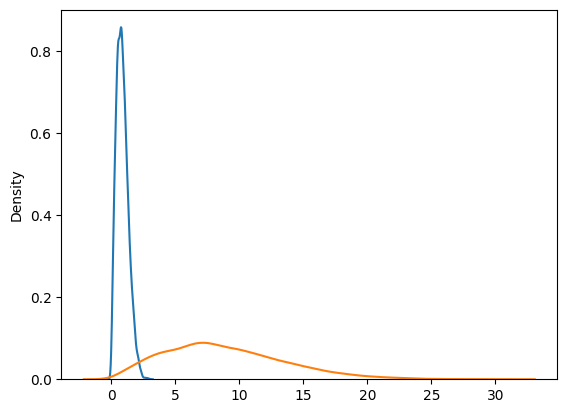

In [8]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

Note the rhat statistic warning here: This means the MCMC sampling chains are not identically distributed. It is recommended to do more draws with the Slice Sampler compared to MCMC.

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [46]:
model_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
    }

map_fit = ParetoNBDModel(df)
map_fit.fit()

lt_fit = {
    'r': 0.5532631052128189,
     'alpha': 10.577412770186461,
     's': 0.6062085898176242,
     'beta': 11.668105047300301,
    }

print("MAP Fit:") 
print(map_fit.fit_summary())


MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64



MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64
1.79 s ± 7.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
map_fit = ParetoNBDModel(df)

# TODO: build_model() and fit() methods both return NoneType objects. 
#pnbd.idata not yet created at this point

# pnbd.sample_prior_predictive() can be used after calling build_model and before fitting, 
# it will return an xarray.Dataset, but also create the pnbd.idata arviz.InferenceData object
map_fit.sample_prior_predictive()

# fitting the model will overwrite the prior_predictive idata object
map_fit.fit(fit_method='map')

# assert pnbd.fit_result == pnbd.idata.posterior

map_fit.idata

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [51]:
# fit same model with MCMC to compare return arviz outputs
# SliceSampler cannot be used with HalfFlat priors
mcmc_fit = ParetoNBDModel(df,model_config)
mcmc_fit.fit(fit_method='slice')


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]


EOFError: 

In [74]:
# posterior predictive checks not directly supported,
# because GammaGammaModel and BetaGeoModel use Potentials to calculate logp
with mcmc_fit.model:
    post_idata = pm.sample_posterior_predictive(mcmc_fit.idata)

mcmc_fit.idata.extend(post_idata)
mcmc_fit.idata

Sampling: [likelihood]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data
	> prior
	> prior_predictive
	> posterior_predictive

In [27]:
mcmc_fit.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.562,0.045,0.483,0.650,0.001,0.001,1851.0,2131.0,1.0
alpha,10.680,0.821,9.180,12.287,0.019,0.013,1848.0,1829.0,1.0
s,0.607,0.117,0.401,0.826,0.003,0.002,1587.0,1684.0,1.0
beta,11.689,3.749,5.397,18.738,0.096,0.069,1542.0,1888.0,1.0


In [31]:
print("MAP Fit:") 
print(map_fit.fit_summary())

lt_fit = {
    'r': 0.5532631052128189,
     'alpha': 10.577412770186461,
     's': 0.6062085898176242,
     'beta': 11.668105047300301,
    }

slice_fit.fit_summary()

MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.561,0.044,0.481,0.646,0.001,0.001,1303.0,2691.0,1.00
alpha,10.663,0.815,9.154,12.228,0.020,0.014,1608.0,2946.0,1.00
s,0.607,0.122,0.392,0.833,0.005,0.004,504.0,921.0,1.01
beta,11.650,3.841,5.112,18.739,0.174,0.123,490.0,979.0,1.01


array([<Axes: title={'center': 'r'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 's'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

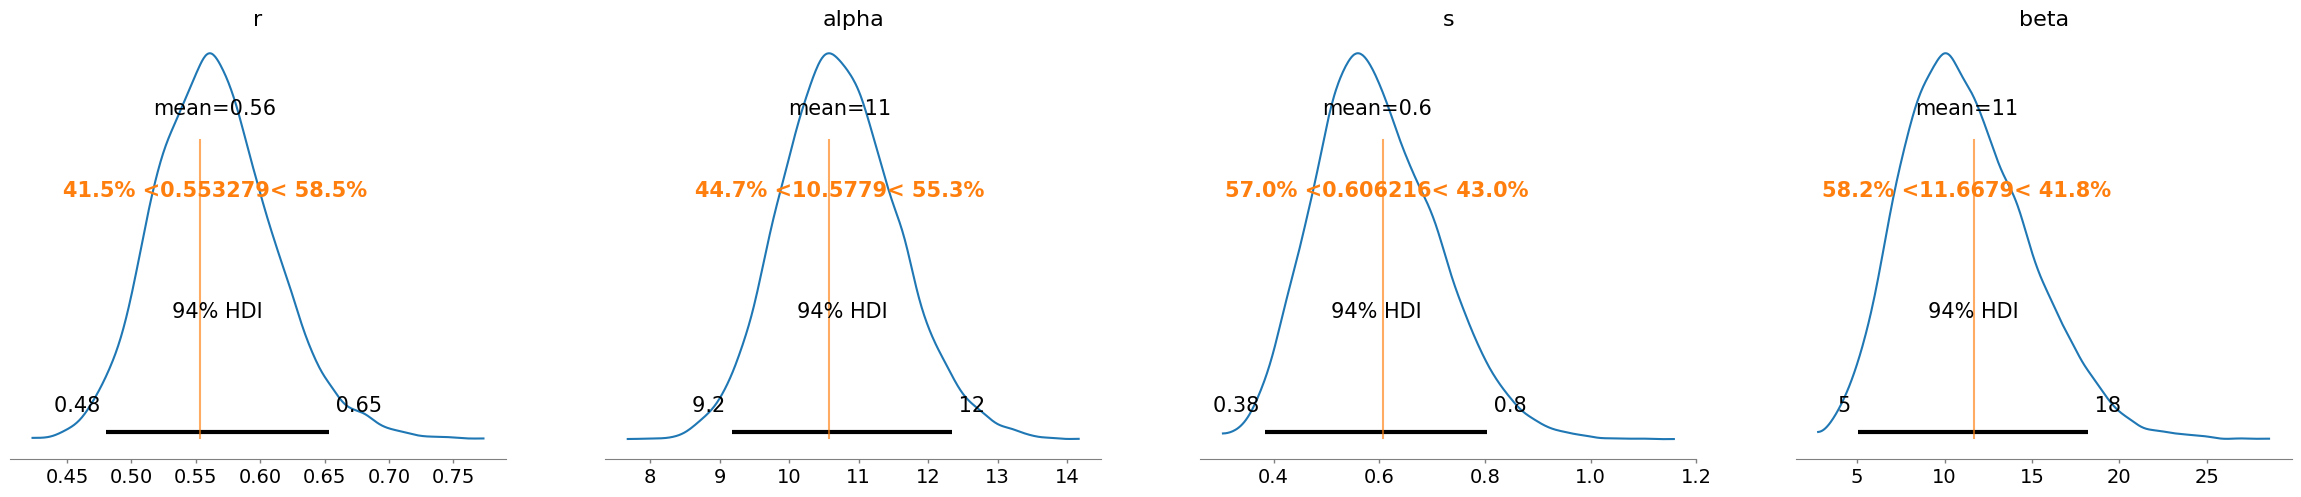

In [19]:
az.plot_posterior(slice_fit.idata, ref_val=list(lt_fit.values()))

Energy Plot
https://python.arviz.org/en/stable/api/generated/arviz.plot_energy.html

<Axes: title={'center': 'Plot Prior Predictive'}>

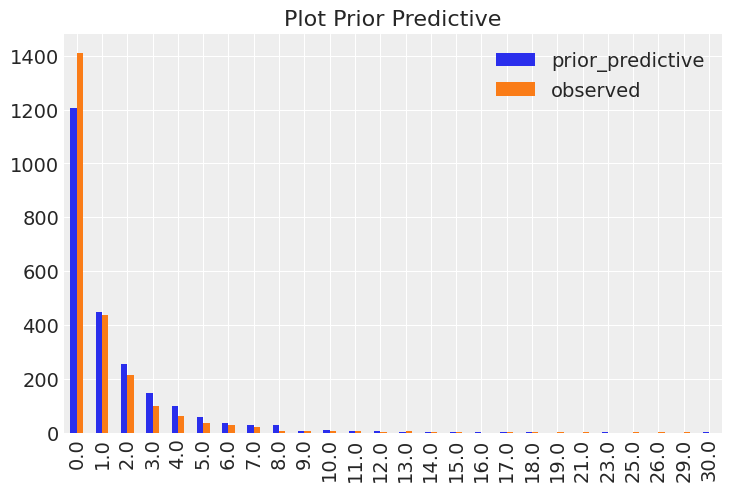

In [86]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<Axes: title={'center': 'Plot Post Predictive'}>

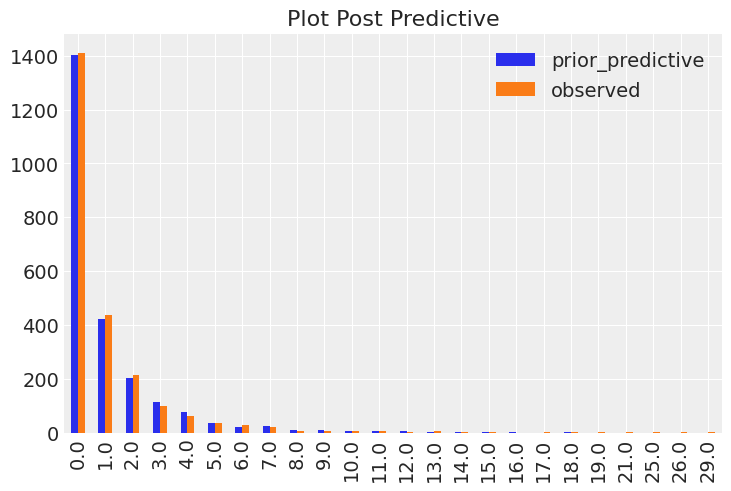

In [85]:
post_pred_freq = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_post_pred = pd.DataFrame({"prior_predictive": post_pred_freq, "observed": obs_freq})
plot_post_pred.plot(kind="bar", title = "Plot Post Predictive")

#az.plot_dist(post_idata.posterior_predictive)


Text(0.5, 1.0, 'Prior Predictive ECDF Plot')

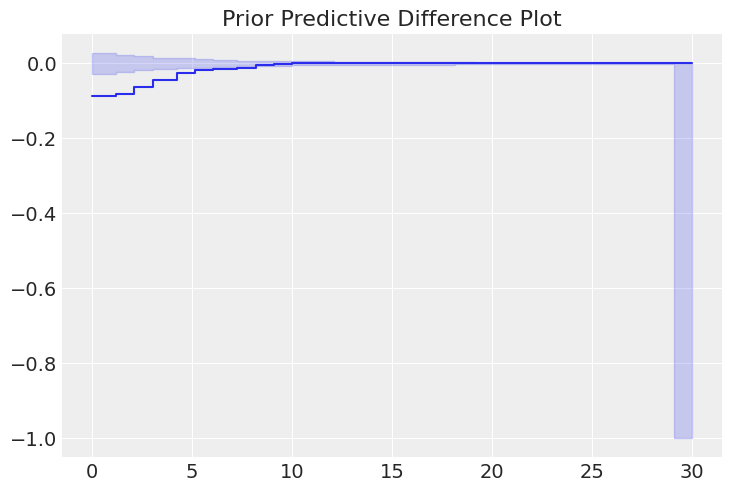

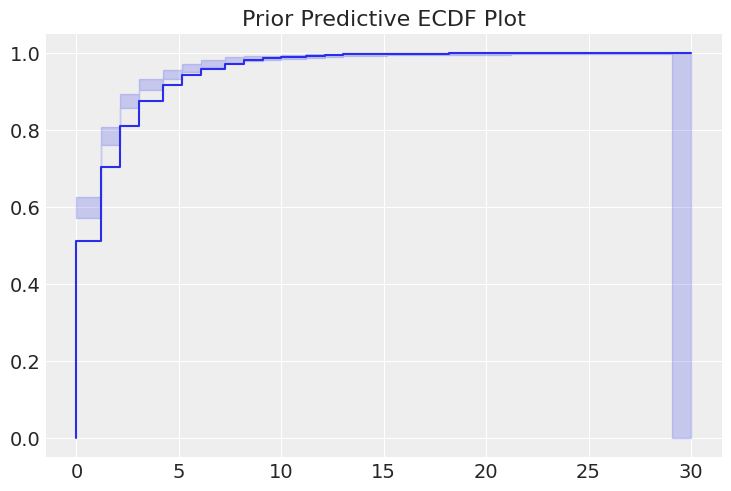

In [88]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
prior_pred_freq_array = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Prior Predictive Difference Plot")
az.plot_ecdf(prior_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Prior Predictive ECDF Plot")

Text(0.5, 1.0, 'Posterior Predictive ECDF Plot')

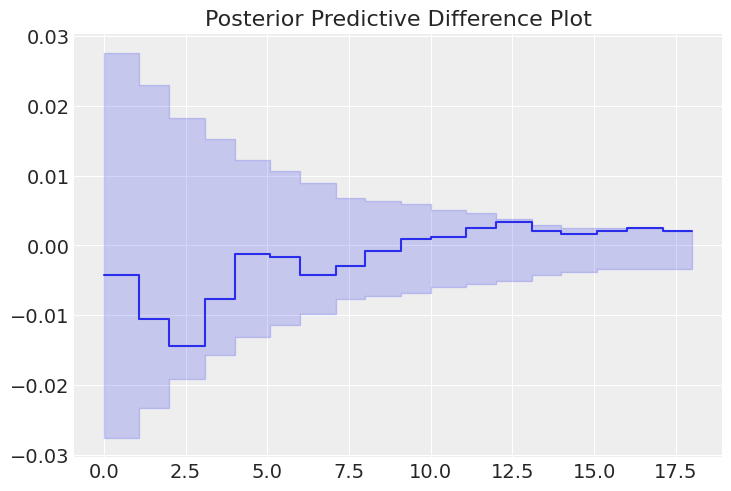

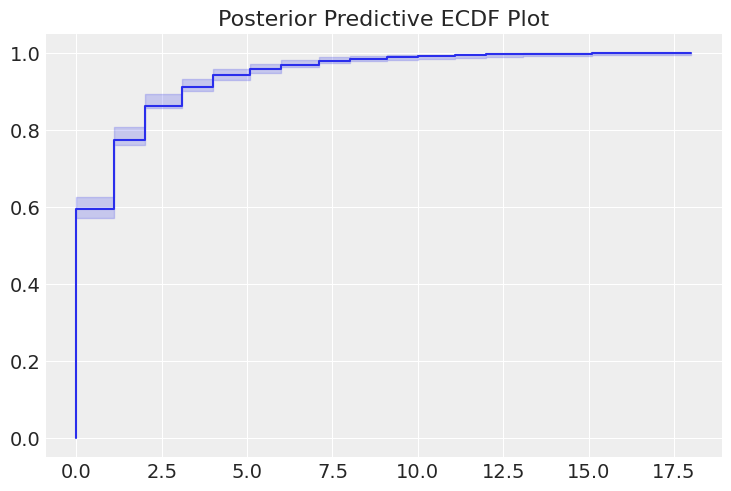

In [84]:
obs_freq_array = mcmc_fit.idata.observed_data['likelihood'][...,1]
post_pred_freq_array = mcmc_fit.idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True, difference=True).set_title("Posterior Predictive Difference Plot")
az.plot_ecdf(post_pred_freq_array, obs_freq_array, confidence_bands = True).set_title("Posterior Predictive ECDF Plot")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [32]:
customer_dropout_mcmc = mcmc_fit.distribution_new_customer_dropout()
customer_purchase_rate_mcmc = mcmc_fit.distribution_new_customer_purchase_rate()
customer_population_mcmc = mcmc_fit.distribution_customer_population()

customer_dropout_map = map_fit.distribution_new_customer_dropout()
customer_purchase_rate_map = map_fit.distribution_new_customer_purchase_rate()
customer_population_map = map_fit.distribution_customer_population()


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


Sampling: [population_dropout]


Sampling: [population_purchase_rate]


Sampling: [customer_population]


Text(0.5, 1.0, 'Customer Dropout Distribution')

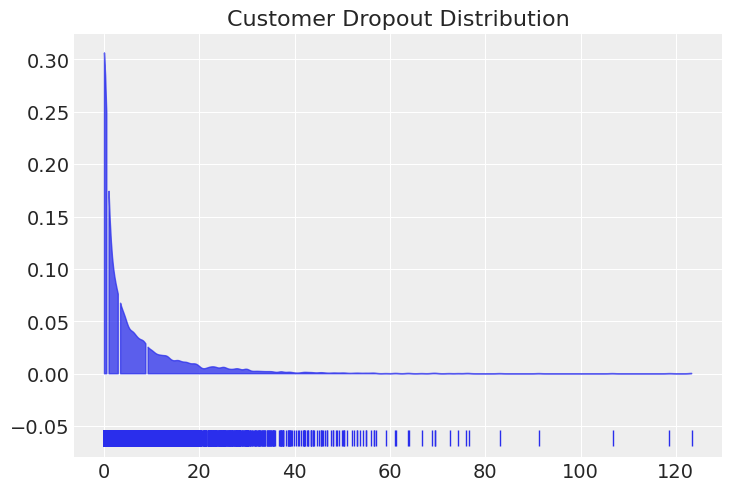

In [111]:
az.plot_dist(customer_dropout_mcmc, rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

Text(0.5, 1.0, 'Customer Dropout Rate Distribution w/ MAP Fit')

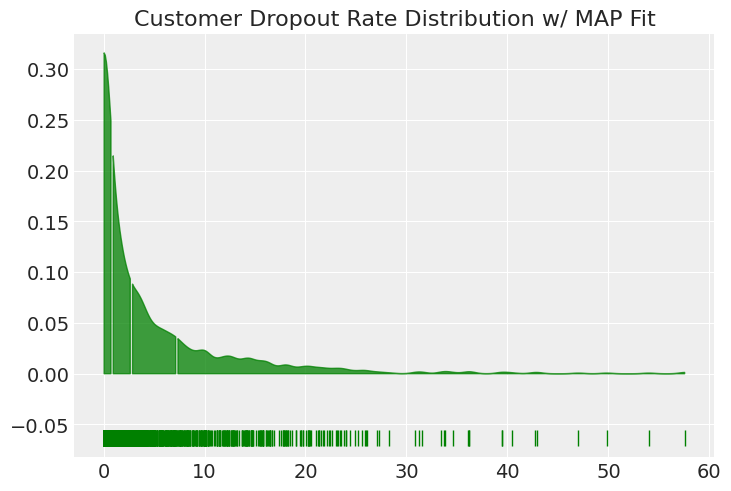

In [112]:
# Note the array indexing required for MAP fit plotting
az.plot_dist(customer_dropout_map[0][0], rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Rate Distribution w/ MAP Fit")

In [34]:
obs_freq = mcmc_fit.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
#prior_pred_freq = mcmc_fit.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()
customer_population_map

# actual_counts = pd.Series(x).value_counts().sort_index()
# simulated_counts = pd.Series(model_freq).value_counts().sort_index()

# plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
# plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<xarray.DataArray 'customer_population' (chain: 4, draw: 1000,
                                         customer_population_dim_2: 2357,
                                         customer_population_dim_3: 2)>
array([[[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [33.22348507,  3.        ],
         [17.78219702,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [15.12256784,  1.        ]],

        [[36.55367967,  5.        ],
         [30.82568583,  2.        ],
         [ 0.        ,  0.        ],
         ...,
...
         ...,
         [ 0.        ,  0.        ],
         [19.43196482,  3.        ],
         [ 0.        ,  0.        ]],

        [[36.3525494 ,  6.        ],
         [ 0.        ,  0.        ],
         [38.4767482 , 12.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [26.8154956 , 10.        ]],

        [[ 0.        ,  0.        ],
         [33.953614  ,  7.        ],
         [19.74782928,  5.        ],
         ...,
         [ 0.        ,  0.        ],
         [ 6.49108868,  1.        ],
         [13.13369364,  4.        ]]]])
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * customer_population_dim_2  (customer_population_dim_2) int64 0 1 ... 2356
  * customer_population_dim_3  (customer_population_dim_3) int64 0 1

# Prior Predictive Plots for the Latent Dropout and Purchase Rate Distributions  are doable, but not directly supported. It's also important to know that since both distributions have identical Priors, there is no difference in plotting between them.

array([[<Axes: title={'center': 'x'}>]], dtype=object)

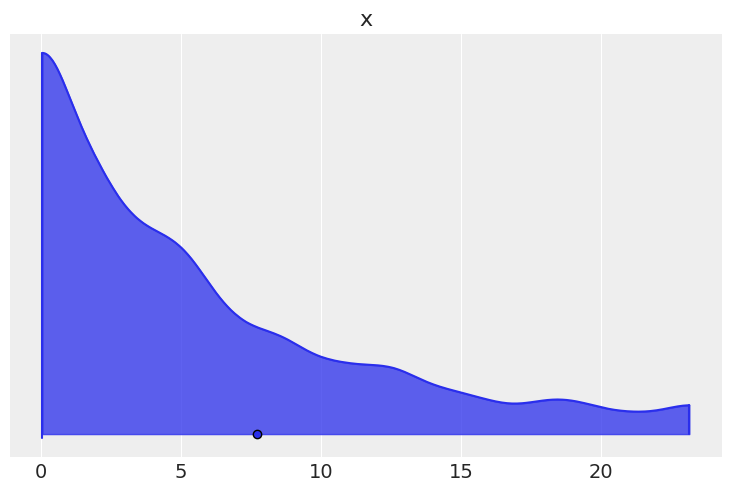

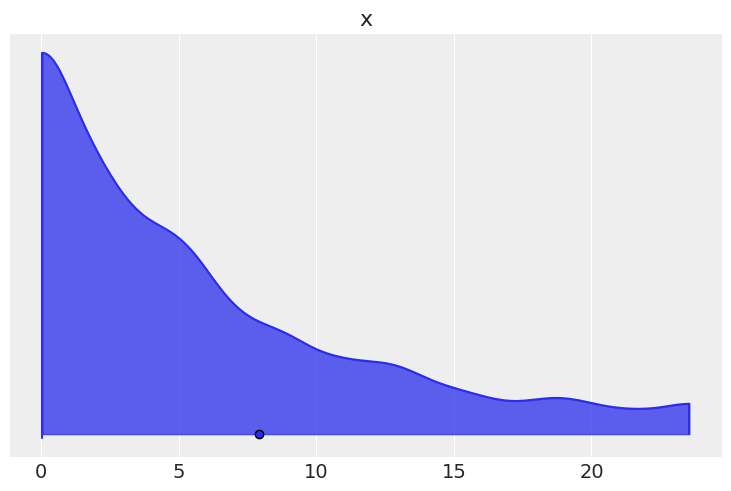

In [204]:
r_prior = mcmc_fit.idata.prior["r"]
alpha_prior = mcmc_fit.idata.prior["alpha"]
s_prior = mcmc_fit.idata.prior["s"]
beta_prior = mcmc_fit.idata.prior["beta"]

purchase_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=r_prior.values[..., None].mean(),  
        beta=1 / alpha_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

dropout_rate_dist = pm.draw(  
    pm.Gamma.dist(  
        alpha=s_prior.values[..., None].mean(),  
        beta=1 / beta_prior.values[..., None].mean(),  
        shape=1000,  
    ),  
    random_seed=42)

az.plot_density(purchase_rate_dist,point_estimate="mean", shade=.75)
az.plot_density(dropout_rate_dist,point_estimate="mean", shade=.75)

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
